In [2]:
import imaging_behavior_functions
#import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary

In [18]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/hDeltaB_imaging/qualified_sessions/bar_jump/"
example_path_data = base_path+"20230426-8_MBON09hDeltaB_syntGCAMP7f_long_nojump_fly4/data/"
example_path_results = base_path+"20230426-8_MBON09hDeltaB_syntGCAMP7f_long_nojump_fly4/results/"
trial_num = 1
odor_threshold = 5
time_interval_threshold = 16  # Assuming time is in seconds or an equivalent unit
k = 8
window_size = 30

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
#behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
combined_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
#smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

In [20]:
neural_df

,time,hDeltaB_0,hDeltaB_1,hDeltaB_2,hDeltaB_3,hDeltaB_4,hDeltaB_5,hDeltaB_6,hDeltaB_7,hDeltaB_8,...,hDeltaB_16,hDeltaB_17,hDeltaB_18,hDeltaB_19,hDeltaB_20,hDeltaB_21,hDeltaB_22,hDeltaB_23,hDeltaB_24,hDeltaB_25
0,0.000000,-0.225210,-0.087920,-0.089012,0.062202,-0.017969,-0.007947,-0.063649,0.176683,0.331685,...,1.659966,0.962787,0.798500,0.754827,0.679093,0.609748,0.366515,0.174485,0.245342,0.257239
1,0.240513,-0.226798,-0.066522,-0.071920,0.039388,-0.046686,-0.007157,-0.047345,0.175496,0.399964,...,1.699779,1.033172,0.715645,0.681758,0.693626,0.589022,0.306681,0.173366,0.175825,0.270140
2,0.481026,-0.220549,-0.102081,-0.109595,-0.047740,-0.092513,-0.077101,-0.070187,0.230936,0.547051,...,1.845435,1.077363,0.646536,0.596222,0.688301,0.510941,0.224949,0.155746,0.074768,0.152358
3,0.721539,-0.202632,-0.174490,-0.185600,-0.151888,-0.104475,-0.121979,-0.099898,0.347553,0.766397,...,2.062725,1.073487,0.625154,0.535448,0.583915,0.326430,0.122665,0.115568,-0.008546,-0.007471
4,0.962052,-0.090808,-0.180887,-0.191462,-0.211292,-0.058294,-0.073274,-0.054596,0.525905,0.949366,...,2.162380,1.052210,0.586100,0.488604,0.415239,0.127419,0.013035,0.053866,-0.054718,-0.062019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,598.877285,0.472361,0.522669,0.493021,0.596720,0.513153,0.498474,0.496289,0.674980,0.966123,...,0.768251,0.424558,0.358743,0.449113,0.490582,0.366042,0.277863,0.368478,0.322860,0.469821
2491,599.117798,0.493869,0.469947,0.461631,0.575459,0.483151,0.513560,0.475524,0.666281,0.875367,...,0.677548,0.440046,0.455566,0.554397,0.554683,0.417799,0.319403,0.396394,0.400793,0.517383
2492,599.358311,0.475650,0.390661,0.343368,0.549957,0.455173,0.456165,0.387719,0.556797,0.741637,...,0.713707,0.541674,0.586301,0.645726,0.557613,0.416813,0.325756,0.392224,0.440523,0.534687
2493,599.598824,0.403117,0.371869,0.261062,0.521615,0.428141,0.396828,0.333580,0.524789,0.715290,...,0.891709,0.637024,0.622548,0.674784,0.524533,0.402130,0.323127,0.375024,0.465717,0.524006


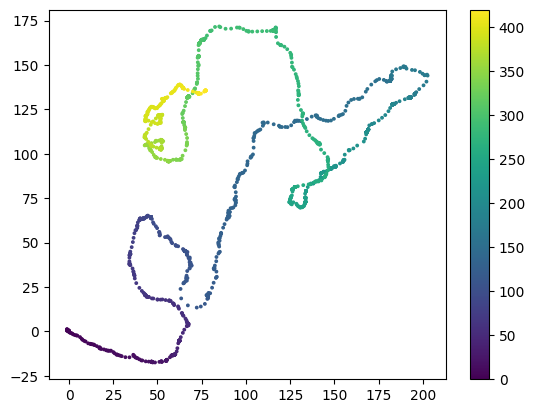

In [14]:
fig = plt.scatter(behav_df.xPos,behav_df.yPos,s=3,c = behav_df.time)
plt.colorbar(fig)

In [16]:
jumpbar_pd = pd.read_csv(example_path_data+'../panel_heading_1.txt',names = ['panel_heading','time','count'])
jumpbar_pd

,panel_heading,time,count
0,0.000000,0.024992,1
1,6.267198,0.033990,2
2,6.246718,0.037988,3
3,6.230978,0.042986,4
4,6.216707,0.048985,5
...,...,...,...
21393,2.601488,437.512156,21394
21394,2.601415,437.532149,21395
21395,2.601354,437.552143,21396
21396,2.600602,437.572137,21397


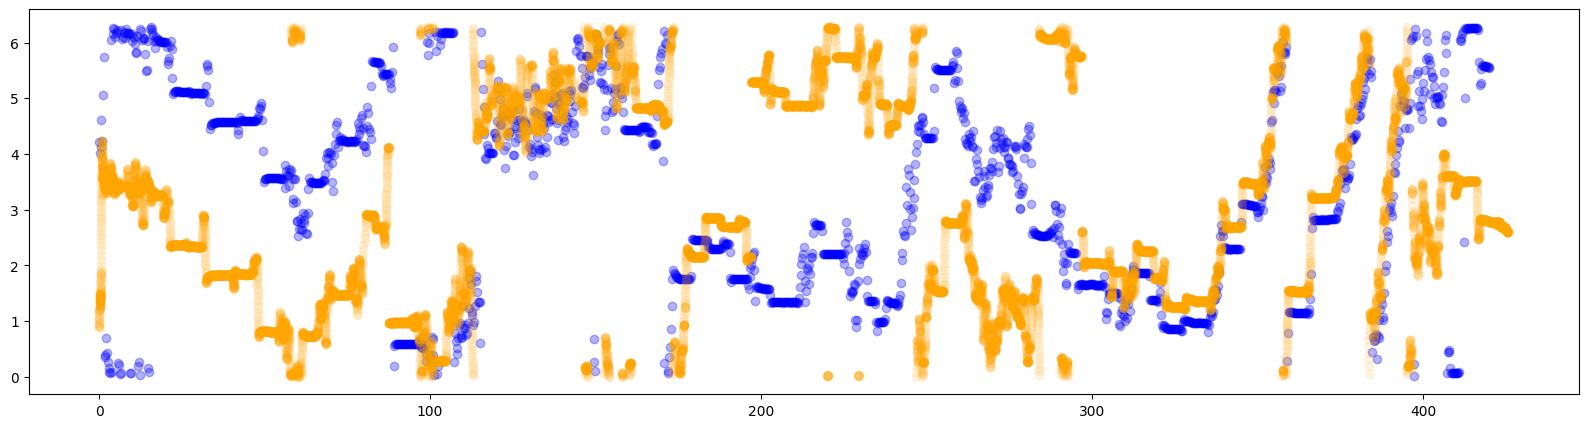

In [17]:
fig_ex, ax = plt.subplots(figsize=[20,5])
x1 = 3000
x2 = 600
ax.scatter(behav_df.time[0:len(behav_df)], behav_df.heading[0:len(behav_df)],color ='blue',alpha = 0.3)
ax.scatter(jumpbar_pd.time[:len(jumpbar_pd)-x2], jumpbar_pd.panel_heading[x2:len(jumpbar_pd)],color ='orange',alpha = 0.1)


In [17]:
heading_intp = np.interp(behav_df.time, jumpbar_pd.time[:-x2], 2*np.pi-jumpbar_pd.panel_heading[x2:])
behav_df['heading_jump'] = heading_intp

In [18]:
heading_adj = 2*np.pi-jumpbar_pd.panel_heading[x2:]
jump_label = np.abs(np.diff(np.unwrap(heading_adj)))>2 
jump_idx = np.where(jump_label)

Text(0, 0.5, 'fw velocity (mm/s)')

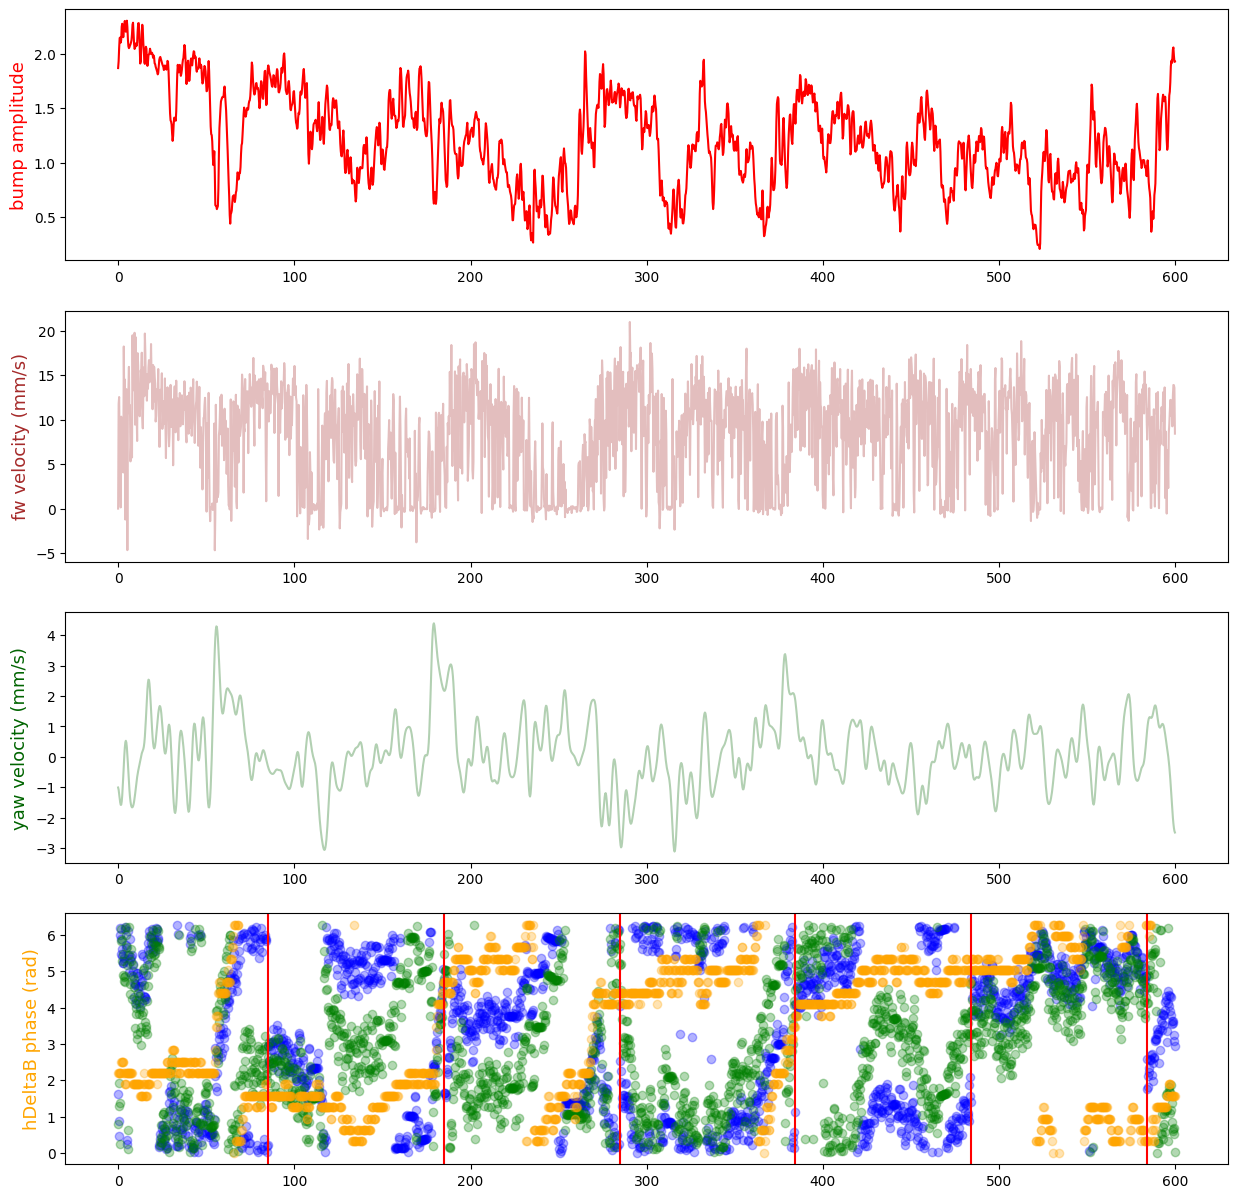

In [20]:
fig_ex, ax = plt.subplots(4,1,figsize=[15,15])
ind1 = 0
ind2 = len(behav_df) 
ax[0].plot(behav_df.time[ind1:ind2], param_df.amplitude[ind1:ind2],color = 'red')
ax[0].set_ylabel('bump amplitude', fontsize = 13, color = 'red')
ax[3].scatter(behav_df.time[ind1:ind2], heading_intp[ind1:ind2],color ='blue',alpha = 0.3)
ax[3].scatter(behav_df.time[ind1:ind2], behav_df.heading[ind1:ind2],color ='green',alpha = 0.3)
ax[3].scatter(behav_df.time[ind1:ind2], 2*np.pi-param_df.phase[ind1:ind2],color ='orange',alpha = 0.3)
#ax[3].scatter(jumpbar_pd.time[:-600], 2*np.pi-jumpbar_pd.panel_heading[600:],color ='orange',alpha = 0.1)
for i in range(len(jump_idx[0])):
    ax[3].axvline(jumpbar_pd.time[jump_idx[0][i]],color ='red')
ax[3].set_ylabel('hDeltaB phase (rad)', fontsize = 13, color = 'orange')
#ax2 = ax[3].twinx()
ax[2].plot(behav_df.time[ind1:ind2], imaging_behavior_functions.apply_gaussian_smoothing(behav_df.yawV[ind1:ind2],5),color='darkgreen',alpha = 0.3)
ax[2].set_ylabel('yaw velocity (mm/s)', fontsize = 13, color = 'darkgreen')
ax[1].plot(behav_df.time[ind1:ind2],behav_df.fwV[ind1:ind2], color = 'brown',alpha = 0.3)
ax[1].set_ylabel('fw velocity (mm/s)', fontsize = 13, color = 'brown')

In [13]:
# Function to find the index of the closest value
def find_closest_indices(values, highlight_values):
    indices = []
    for value in highlight_values:
        # Compute absolute difference and find the index of the minimum
        index = np.abs(values - value).argmin()
        indices.append(index)
    return indices

In [14]:
highlight_times = np.array(jumpbar_pd.time[jump_idx[0]])
# Find the index of the closest value for each highlight value
highlight_indices = find_closest_indices(behav_df.time, highlight_times)

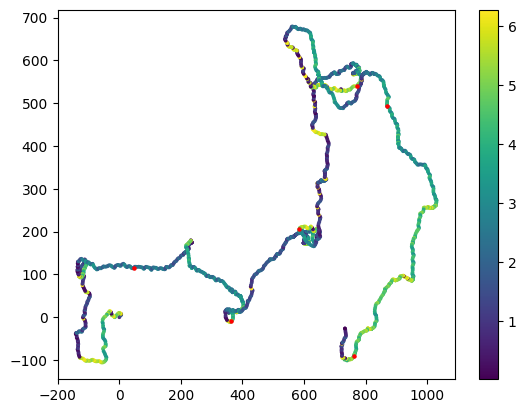

In [15]:
fig = plt.scatter(xPos,yPos,s=3,c = behav_df.heading)
# Highlight specific time points in red
for idx in highlight_indices:
    plt.scatter(xPos[idx], yPos[idx], s=5,color='red')
plt.colorbar(fig)